In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Preprocessing

Define functions that scale and one-hot encode the data. We will use the scaled data for everything in this notebook file, but only use one-hot encoding for fitting logistic regression and NOT for anything tree based such as boruta and mutual information.

In [2]:
from sklearn.preprocessing import MinMaxScaler

def scale(df, nominal):

    scaler = MinMaxScaler()

    for var in df.columns:
            
        if var not in nominal:
            raw = df[var].to_numpy()
            raw = raw.reshape(-1, 1)

            scaler.fit(raw)
            scaled = scaler.transform(raw)
            df[var] = scaled

    return df

#since we'll use the scaled data for everything, scale X now

nominal = [
            'Marital status',      
            'Application mode',          
            'Application order',         
            'Course',                    
            'Daytime/evening attendance',
            'Previous qualification',    
            'Nationality',               
            "Mother's qualification",    
            "Father's qualification",    
            "Mother's occupation",       
            "Father's occupation",       
            'Displaced',              
            'Educational special needs', 
            'Debtor',                    
            'Tuition fees up to date',   
            'Gender',                                              
            'Scholarship holder',                                  
            'International'
            ]

X = scale(X, nominal)
X_train = scale(X_train, nominal)
X_test = scale(X_test, nominal)

In [3]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(transform_df, fit_df, nominal):
# requires passing a list of the nominal columns 
# fit_df is the dataframe to fit the encoder onto
# transform_df is the dataframe to transform with the encoder

    # initialize encoder object
    # use 'infrequent_if_exist' for unseen categories since some features are very sparse
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', drop='first')

    # fit
    fit = encoder.fit(fit_df[nominal])
    
    # transform
    encoded = encoder.transform(transform_df[nominal])

    # convert result to df
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal))

    # add results to full data
    data_one_hot = pd.concat([transform_df.reset_index(drop=True), 
                              one_hot_df.reset_index(drop=True)], 
                              axis=1)

    # drop original nominal columns
    data_one_hot = data_one_hot.drop(nominal, axis=1)

    return data_one_hot

# Feature Selection

The process for feature selection is not straightforward due to the mix of nominal and interval features. The need to encode the nominal features eliminates wrapper methods. In the case of one-hot/dummy encoding, they will eliminate individual levels from a feature. In the case of label encoding, the features will be misinterpreted as ordinal. Tree-based algorithms are likely the best approach out of all the supervised methods. We can try an ensemble of different methods and compare performance. In the event that none are the clear winner, we can use them in a voting selector. <br>

These are the feature selection methods we'll use:<br>

**Boruta**<br>
This is a highly successful tree-based algorithm that will likely do better than a simple filter method and can be used for any classification model. <br>

**Mutual information**<br>
We can filter by mutual information since it's able to capture any kind of dependency. <br>

**Recursive feature elimination**<br>
As discussed, our nominal data is probably an issue for this method, but there's no harm in trying it. <br>


In [4]:
# BORUTA

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# BorutyPy expects numpy arrays
X = X_train.values
y = y_train.values
y = y.ravel()

# fit random forest classifier
rf = RandomForestClassifier(n_jobs=-1, class_weight={0:0.7, 1:0.3}, max_depth=5)
rf.fit(X,y)

# initialize and fit Boruta selector
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=1)
feat_selector.fit(X, y)

# display selected features
boruta_subset = [feature for feature, keep in zip(X_train.columns, feat_selector.support_) if keep]
boruta_subset

['Application mode',
 'Course',
 'Previous qualification (grade)',
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)']

In [5]:
# BORUTA TEST

from sklearn.linear_model import LogisticRegressionCV

X_train_boruta = X_train[boruta_subset]
X_test_boruta = X_test[boruta_subset]

# one-hot encode data
nominal = ['Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']
X_train_boruta_oh = one_hot(X_train_boruta, X_train_boruta, nominal)
X_test_boruta_oh = one_hot(X_test_boruta, X_train_boruta, nominal)

# fit logistic regression to get accuracy score
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_boruta_oh, y)
score = clf.score(X_test_boruta_oh, y_test)
print(f'Boruta accuracy: {score}')

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Boruta accuracy: 0.875


In [8]:
# MUTUAL INFORMATION

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# SelectKBest expects numpy arrays
X = X_train.values
y = y_train.values
y = y.ravel()

select_best = SelectKBest(mutual_info_classif, k=19) #match the number of features boruta selected
select_best.fit(X, y)
mi_subset = X_train.columns[select_best.get_support()]
mi_subset

Index(['Application mode', 'Course', 'Previous qualification',
       'Previous qualification (grade)', 'Mother's qualification',
       'Father's qualification', 'Father's occupation', 'Debtor',
       'Tuition fees up to date', 'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'],
      dtype='object')

In [11]:
# MUTUAL INFO TEST

from sklearn.linear_model import LogisticRegressionCV

X_train_mi = X_train[mi_subset]
X_test_mi = X_test[mi_subset]

# one hot encode data
nominal = ['Application mode', 'Course', "Mother's qualification", "Father's qualification", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Scholarship holder']
X_train_mi_oh = one_hot(X_train_mi, X_train_mi, nominal)
X_test_mi_oh = one_hot(X_test_mi, X_train_mi, nominal)

# test the mi feature subset by finding the accuracy score
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_mi_oh, y)
score = clf.score(X_test_mi_oh, y_test)
print(f'Mutual information accuracy: {score}')

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mutual information accuracy: 0.8757530120481928


In [12]:
# check for multicolinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor 

X_boruta = X_train[boruta_subset]
X_mi = X_train[mi_subset]

vif_boruta = pd.DataFrame() 
vif_mi = pd.DataFrame() 

vif_boruta['Feature'] = X_boruta.columns 
vif_mi['Feature'] = X_mi.columns 
  
# calculating VIF for each feature 
vif_boruta['VIF'] = [variance_inflation_factor(X_boruta.values, i) 
                          for i in range(len(X_boruta.columns))] 
vif_mi['VIF'] = [variance_inflation_factor(X_mi.values, i) 
                          for i in range(len(X_mi.columns))] 

In [13]:
vif_boruta

,Feature,VIF
0,Application mode,3.260958
1,Course,29.218255
2,Previous qualification (grade),13.192101
3,Mother's occupation,6.386088
4,Father's occupation,6.447701
5,Admission grade,8.922881
6,Debtor,1.327177
7,Tuition fees up to date,8.751157
8,Gender,1.619831
9,Scholarship holder,1.479733


In [14]:
sum(vif_boruta['VIF'])

496.9751045909627

In [15]:
vif_mi

,Feature,VIF
0,Application mode,3.802803
1,Course,29.583547
2,Previous qualification,1.513132
3,Previous qualification (grade),7.601451
4,Mother's qualification,3.835881
5,Father's qualification,4.376275
6,Father's occupation,1.222005
7,Debtor,1.317128
8,Tuition fees up to date,8.758926
9,Scholarship holder,1.503996


In [16]:
sum(vif_mi['VIF'])

480.57699011126357

Both feature subsets have a lot of multicolinearity. Let's prune out the features with the highest VIF scores and see if that affects accuracy. 

In [27]:
# PRUNE MULTICOLINEAR FEATURES

def get_vif(df, subset):
# recalculates vif scores after dropping a feature

    X = X_train[subset]
    
    df['VIF'] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
    
    return df

def drop_max(df):
# iteratively drops the feature with highest vif score

    while max(df['VIF'] > 50):

        # drop feature with the highest vif
        label = df.index[df['VIF'] == max(df['VIF'])]
        df = df.drop(label, axis=0)

        # recalculate VIF scores
        subset = df['Feature'].to_list()
        df = get_vif(df, subset)

    return df

# get new dataframes with the pruned feature subsets
# use copies of the dataframes with the original subsets so they aren't altered
new_boruta = drop_max(vif_boruta.copy())
new_mi = drop_max(vif_mi.copy())

new_boruta = new_boruta.reset_index(drop=True)
new_mi = new_mi.reset_index(drop=True)

In [18]:
new_boruta

,Feature,VIF
0,Application mode,3.258991
1,Course,29.071295
2,Previous qualification (grade),13.169923
3,Mother's occupation,6.385860
4,Father's occupation,6.447386
5,Admission grade,8.922251
6,Debtor,1.327148
7,Tuition fees up to date,8.742941
8,Gender,1.618546
9,Scholarship holder,1.476391


In [22]:
new_mi

,Feature,VIF
0,Application mode,3.801697
1,Course,29.449891
2,Previous qualification,1.512306
3,Previous qualification (grade),7.586888
4,Mother's qualification,3.828542
5,Father's qualification,4.376272
6,Father's occupation,1.222002
7,Debtor,1.317117
8,Tuition fees up to date,8.749660
9,Scholarship holder,1.499432


In [28]:
# TEST NEW FEATURE SUBSETS

from sklearn.linear_model import LogisticRegressionCV

# boruta data
X_train_boruta = X_train[new_boruta['Feature'].to_list()]
X_test_boruta = X_test[new_boruta['Feature'].to_list()]

# one hot encode boruta data
nominal = ['Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder']
X_train_boruta_oh = one_hot(X_train_boruta, X_train_boruta, nominal)
X_test_boruta_oh = one_hot(X_test_boruta, X_train_boruta, nominal)

# mutual info data
X_train_mi = X_train[new_mi['Feature'].to_list()]
X_test_mi = X_test[new_mi['Feature'].to_list()]

# one hot encode mutual info data
nominal = ['Application mode', 'Course', "Mother's qualification", "Father's qualification", "Father's occupation", 'Debtor', 'Tuition fees up to date', 'Scholarship holder']
X_train_mi_oh = one_hot(X_train_mi, X_train_mi, nominal)
X_test_mi_oh = one_hot(X_test_mi, X_train_mi, nominal)

# test boruta data
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_boruta_oh, y)
score = clf.score(X_test_boruta_oh, y_test)
print(f'Boruta: {score}')

# test mutual info data
clf = LogisticRegressionCV(random_state=1, class_weight={0:0.7, 1:0.3}, solver='newton-cholesky').fit(X_train_mi_oh, y)
score = clf.score(X_test_mi_oh, y_test)
print(f'Mutual info: {score}')

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Boruta: 0.875
Mutual info: 0.8772590361445783


After some trial and error, setting the VIF threshold to 50 allows us to get accuracy scores that are equal to or slighly better than the original boruta and mutual info subsets. Thresholds < 50 reduce accuracy, and thresholds > 50 stop improving it. The two subsets are nearly the same and are very close in terms of model accuracy and overall VIF scores. In my opinion, the Boruta subset is a bit easier to interpret, so we'll go with that.  

In [29]:
final_subset = new_boruta['Feature'].to_list()
final_subset.append('Target')
final_subset

['Application mode',
 'Course',
 'Previous qualification (grade)',
 "Mother's occupation",
 "Father's occupation",
 'Admission grade',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Target']

In [34]:
# create and save the final, preprocessed dataset that will be used 

nominal=['Application mode','Course',"Mother's occupation","Father's occupation",'Debtor','Tuition fees up to date','Gender','Scholarship holder']

all_data = pd.read_csv('LogReg/data_clean.csv')
data_subset =  all_data[final_subset]

X = data_subset.drop('Target', axis=1)
y = data_subset['Target']

X = scale(X, nominal)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

X_train_oh = one_hot(X_train, X_train, nominal)
X_test_oh = one_hot(X_test, X_train, nominal)

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [36]:
X_train_oh.to_csv('LogReg/X_train.csv', index=False)
X_test_oh.to_csv('LogReg/X_test.csv', index=False)
y_train.to_csv('LogReg/y_train.csv', index=False)
y_test.to_csv('LogReg/y_test.csv', index=False)

# Model Tuning

In [30]:
#load data

X_train = pd.read_csv('LogReg/X_train.csv')
X_test = pd.read_csv('LogReg/X_test.csv')

y_train = pd.read_csv('LogReg/y_train.csv')
y_test = pd.read_csv('LogReg/y_test.csv')

### Vanilla

Let's inspect the perfomance of the vanilla model to compare for later.

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer, ConfusionMatrixDisplay, RocCurveDisplay

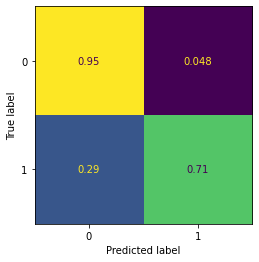

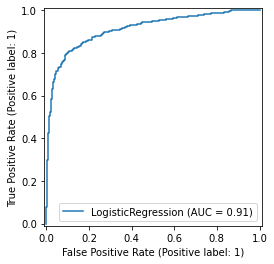

In [51]:
# CONFUSION MATRIX

clf_vanilla = LogisticRegression().fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(clf_vanilla, X_test, y_test, normalize='true', colorbar=False)
RocCurveDisplay.from_estimator(clf_vanilla, X_test, y_test)

0.48% of true negative cases are falsely predicted. 29% of true positive cases are falsely predicted. That's a huge rate of false negatives. We'd rather have some bias toward false positives. 

### Hyperparameters

Use grid search to evaluate the different possible parameter combinations.

In [32]:
from sklearn.model_selection import GridSearchCV

# define possible parameters
parameters = {'penalty':['l1', 'l2'], # exclude penalties 'none' and 'elasticnet' because they will produce NaN
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]} # use logarithmic scale to test wide range of C values

# fit 
lrg = LogisticRegression()
f1 = make_scorer(f1_score)
clf = GridSearchCV(lrg, parameters, scoring=['accuracy', 'recall', 'f1'], return_train_score=True, refit=False)

y_train = y_train.to_numpy()
y_train = y_train.ravel()

clf.fit(X_train, y_train)

# see results
gs_results = pd.DataFrame(clf.cv_results_)

c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Melanie\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

Filter the results dataframe and reformat into a digestible form.

In [33]:
# remove rows with NaN
# these rows represent incompatible parameter combinations
gs_results = gs_results.dropna(axis=0)

# columns of interest
columns = ['param_C', 'param_penalty', 'param_solver', 
           'mean_test_accuracy', 
           'mean_test_recall', 
           'mean_test_f1']

# sort by mean_test_score
gs_recall = gs_results[columns].sort_values(by='mean_test_recall', axis=0, ascending=False, ignore_index=True)
gs_accuracy = gs_results[columns].sort_values(by='mean_test_accuracy', axis=0, ascending=False, ignore_index=True)

In [34]:
# VIEW HIGHEST RECALL
gs_recall.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,100.0,l2,liblinear,0.868867,0.727895,0.785018
1,1000.0,l2,newton-cg,0.867897,0.727890,0.783746
2,10.0,l1,liblinear,0.868867,0.726920,0.784791
3,1000.0,l2,saga,0.868867,0.726915,0.784812
4,100.0,l2,newton-cholesky,0.868544,0.726915,0.784388


In [35]:
# VIEW HIGHEST ACCURACY
gs_accuracy.head()

,param_C,param_penalty,param_solver,mean_test_accuracy,mean_test_recall,mean_test_f1
0,1.0,l1,saga,0.872743,0.721023,0.788433
1,1.0,l1,liblinear,0.872742,0.720042,0.788196
2,10.0,l2,saga,0.870158,0.720038,0.784814
3,10.0,l2,liblinear,0.870158,0.719057,0.784604
4,10.0,l2,newton-cg,0.870158,0.720038,0.784814


Let Model R be the model with the highest recall. Let Model A be the model with the highest accuracy. Model A has a significant improvement in accuracy at the cost of only a slight decrease in recall. We'll proceed with Model A and tune the decision threshold to achieve a higher ratio of false positives. <br>
Overall, it seems that the model is not very sensitive to penalty or solver, and only slightly sensitive to C.

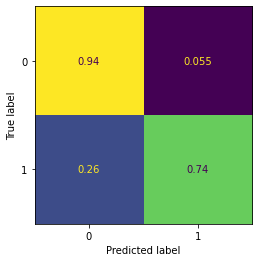

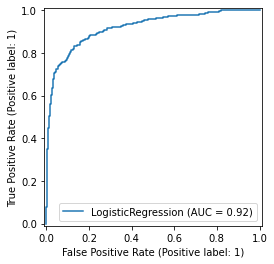

In [52]:
# CONFUSION MATRIX

clf_param_tuned = LogisticRegression(penalty='l1', solver='saga', max_iter=10000).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_param_tuned, X_test, y_test, normalize='true', colorbar=False)
RocCurveDisplay.from_estimator(clf_param_tuned, X_test, y_test)

The confusion matrix for the hyperparameter tuned model is a slight improvement over the vanilla model, but still needs a huge reduction of false negatives. The AUC is only 0.01 higher than the vanilla model. 

### Decision threshold

Now we need to find the optimal threshold. Let's start with finding the max F1 score and adjust from there.

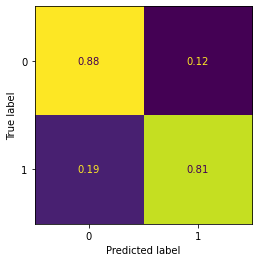

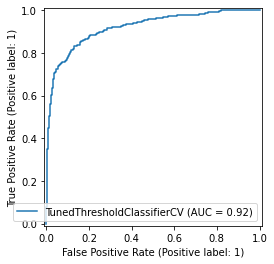

In [53]:
from sklearn.model_selection import TunedThresholdClassifierCV

clf_desc_tuned = TunedThresholdClassifierCV(estimator=clf_param_tuned, scoring=f1, store_cv_results=True).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_desc_tuned, X_test, y_test, normalize='true', colorbar=False)

This confusion matrix is far more balanced than the previous ones, but we'd rather the false positive rate be a bit higher. Let's do this by maximizing a custom scoring method which is the F1 score but with more weight given to recall. 

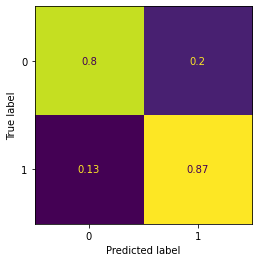

In [65]:
def custom_f1(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    custom_f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    return custom_f1

custom_scorer = make_scorer(custom_f1, beta=1.7)

clf_custom_tuned = TunedThresholdClassifierCV(estimator=clf_param_tuned, scoring=custom_scorer, store_cv_results=True).fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_custom_tuned, X_test, y_test, normalize='true', colorbar=False)

In [77]:
# PLOT SCORES DEPENDENT ON BETA VALUE IN CUSTOM SCORER

y_true = y_test

accuracy = []
recall = []
precision = []

for beta in np.arange(1, 2, 0.1):

    custom_scorer = make_scorer(custom_f1, beta=beta)
    clf_custom_tuned = TunedThresholdClassifierCV(estimator=clf_param_tuned, scoring=custom_scorer, store_cv_results=True).fit(X_train, y_train)
    y_pred = clf_custom_tuned.predict(X_test)

    accuracy.append(accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))


In [81]:
scores = pd.DataFrame({'beta':np.arange(1, 2, 0.1),
                       'accuracy':accuracy,
                       'precision':precision,
                       'recall':recall})

scores

,beta,accuracy,precision,recall
0,1.0,0.860693,0.748858,0.813896
1,1.1,0.860693,0.748858,0.813896
2,1.2,0.860693,0.748858,0.813896
3,1.3,0.860693,0.748858,0.813896
4,1.4,0.856928,0.738255,0.818859
5,1.5,0.856928,0.738255,0.818859
6,1.6,0.847892,0.713376,0.833747
7,1.7,0.824548,0.659774,0.870968
8,1.8,0.822289,0.654917,0.875931
9,1.9,0.822289,0.654917,0.875931
